<a href="https://colab.research.google.com/github/Mattlee10/zone2/blob/main/25_05.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

1. 목표

- HR/HRV 데이터를 활용해 Zone2 감지 + 회복 상태 분석
- 사용자 형태에 따른 간단한 텍스트 피드백 생성

2. 데이터

- Apple Health, Samsung Health CSV(심박수/HRV 포함)


3. 단계별 구현

- 데이터 전처리
  - CSV 로딩 -> 시간 정렬, 결측치 제거
  - HR -> 1분 단위 평균
  - HRV(SDNN or rMSSD) 계산 (연속 구간 필요 시 슬라이딩 윈도우 적용)

- Zone 2 감지
  - 최대 심박수 = 220 - 나이
  - Zone 2 범위 = 60-70% of max HR
  - 해당 구간에 있었던 시간 누적

- 회복/스트레스 분석: HRV 낮고 RHR 높으면 회복 저하
- 요약 텍스트 출력: Rule based or GPT 활용

4. 시각화

- matplotlib로 HR/HRV 변화 그래프
- Zone 2 운동 시간 히트맵
- 추후 Canva/Figma 시각화 연결 포인트 설정

5. 다음 단계

- 리포트 자동 생성(PDF 형태)
- 카카오 공유 메시지 생성 시나리오

# Zone 2 감지 알고리즘

데이터 입력: 웨어러블에서 수집한 시간별 심박수(HR) 데이터를 Pandas DataFrame으로 준비

최대심박수(MHR) 계산
MHR = 220 - 나이

Zone 2 구간 정의

- 최소값: zone2_min = MHR x 0.60
- 최대값: zone2_max = MHR x 0.70

Zone 2 감지: 각 심박수가 zone2_min과 zone2_max 사이에 있는지 불리언 플래그(in_zone2) 생성

구간 요약

- 지속 시간: in_zone2 == True인 행 수 (분 단위)
- 비율: 전체 행 대비 in_zone2 비중

In [ ]:
import pandas as pd

# 1. 데이터 입력 (예시 데이터)
data = {
    'Time': pd.date_range(start='2025-05-12 07:00', periods=10, freq='T'),
    'HR':    [105, 110, 115, 125, 130, 140, 135, 120, 110, 100]
}
df = pd.DataFrame(data)

# 2. 최대심박수(MHR) 계산
age = 30  # 사용자 나이
mhr = 220 - age

# 3. Zone 2 구간 정의
zone2_min = mhr * 0.60
zone2_max = mhr * 0.70

# 4. Zone 2 감지
df['in_zone2'] = df['HR'].between(zone2_min, zone2_max)

# 5. 구간 요약
zone2_duration = df['in_zone2'].sum()  # Zone 2 지속 시간 (분)
zone2_ratio    = df['in_zone2'].mean() # Zone 2 비율

# 결과 출력
print(f"Max HR (MHR): {mhr} bpm")
print(f"Zone 2 범위: {zone2_min:.1f} ~ {zone2_max:.1f} bpm")
print(f"Zone 2 지속 시간: {zone2_duration}분")
print(f"Zone 2 비율: {zone2_ratio:.1%}")

Max HR (MHR): 190 bpm
Zone 2 범위: 114.0 ~ 133.0 bpm
Zone 2 지속 시간: 4분
Zone 2 비율: 40.0%


<ipython-input-1-f515ecd42f51>:5: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  'Time': pd.date_range(start='2025-05-12 07:00', periods=10, freq='T'),


# 데이터 내보내기(Export)

In [10]:
import xml.etree.ElementTree as ET
import pandas as pd

def parse_health_export(xml_path, record_types=None):
    """
    - xml_path: str, export.xml 파일 경로
    - record_types: list or None, 파싱할 Record type 리스트.
    """
    tree = ET.parse(xml_path)
    root = tree.getroot()
    records = []
    for rec in root.findall('Record'):
        rtype = rec.get('type')
        if record_types and rtype not in record_types:
            continue
        val = rec.get('value')
        if val is None:
            continue
        records.append({
            'type': rtype,
            'value': float(val),
            'unit': rec.get('unit'),
            'start': pd.to_datetime(rec.get('startDate')),
            'end': pd.to_datetime(rec.get('endDate'))
        })
    return pd.DataFrame(records)

# 이렇게 정의한 뒤, 원래 쓰시던 record_types 인자로 호출하세요.
xml_path = '/content/drive/MyDrive/export_L.xml'
df = parse_health_export(
    xml_path,
    record_types=[
        'HKQuantityTypeIdentifierHeartRate',
        'HKQuantityTypeIdentifierRestingHeartRate',
        'HKQuantityTypeIdentifierHeartRateVariabilitySDNN'
    ]
)
print(df.head())

                                type    value       unit  \
0  HKQuantityTypeIdentifierHeartRate  80.0000  count/min   
1  HKQuantityTypeIdentifierHeartRate  82.0000  count/min   
2  HKQuantityTypeIdentifierHeartRate  88.0000  count/min   
3  HKQuantityTypeIdentifierHeartRate  69.0000  count/min   
4  HKQuantityTypeIdentifierHeartRate  81.6192  count/min   

                      start                       end  
0 2024-10-10 13:09:52+09:00 2024-10-10 13:09:52+09:00  
1 2024-10-10 13:11:37+09:00 2024-10-10 13:11:37+09:00  
2 2024-10-10 13:17:00+09:00 2024-10-10 13:17:00+09:00  
3 2024-10-10 13:22:03+09:00 2024-10-10 13:22:03+09:00  
4 2024-10-10 13:27:40+09:00 2024-10-10 13:27:40+09:00  


In [11]:
# 1) HR 데이터만 골라서 시간순 정렬
df_hr = df[df['type']=='HKQuantityTypeIdentifierHeartRate'].sort_values('start').reset_index(drop=True)

# 2) 최대심박수 설정
#    • AGE 대신 본인 나이를 숫자로 넣으세요
AGE = 25
max_hr = 220 - AGE
zone_low, zone_high = max_hr * 0.6, max_hr * 0.7

# 3) Zone 2 여부 플래그 추가
df_hr['in_zone2'] = df_hr['value'].between(zone_low, zone_high)

# 4) 연속 구간 탐지:
#    • 측정 간격이 60초 이상 끊기면 새로운 세그먼트로 간주
df_hr['gap_s'] = df_hr['start'].diff().dt.total_seconds().fillna(0)
df_hr['segment'] = (df_hr['gap_s'] > 60).cumsum()

# 5) 세그먼트별 시작·종료 시각과 지속시간 계산
zones = (
    df_hr[df_hr['in_zone2']]
    .groupby('segment')
    .agg(
        start_time=('start','min'),
        end_time=('end','max')
    )
    .reset_index(drop=True)
)
zones['duration_min'] = (zones['end_time'] - zones['start_time']).dt.total_seconds() / 60

# 6) 최소 10분 이상 유지된 구간만 필터
zone2_periods = zones[zones['duration_min'] >= 10].reset_index(drop=True)

# 결과 출력
print(f"Zone 2 (>{zone_low:.0f}–<{zone_high:.0f} bpm) 구간:")
print(zone2_periods)

Zone 2 (>117–<136 bpm) 구간:
                  start_time                  end_time  duration_min
0  2024-11-15 13:22:12+09:00 2024-11-15 13:38:29+09:00     16.283333
1  2024-11-28 14:23:40+09:00 2024-11-28 14:41:02+09:00     17.366667
2  2024-12-13 20:53:21+09:00 2024-12-13 21:11:57+09:00     18.600000
3  2025-01-03 14:13:16+09:00 2025-01-03 14:23:27+09:00     10.183333
4  2025-01-05 12:07:08+09:00 2025-01-05 12:19:49+09:00     12.683333
5  2025-01-05 15:49:58+09:00 2025-01-05 16:01:24+09:00     11.433333
6  2025-02-01 14:05:35+09:00 2025-02-01 14:15:58+09:00     10.383333
7  2025-03-02 14:27:22+09:00 2025-03-02 14:57:03+09:00     29.683333
8  2025-03-11 09:55:43+09:00 2025-03-11 10:11:13+09:00     15.500000
9  2025-03-12 16:19:55+09:00 2025-03-12 16:46:23+09:00     26.466667
10 2025-03-12 17:55:57+09:00 2025-03-12 18:07:32+09:00     11.583333
11 2025-03-14 19:06:18+09:00 2025-03-14 19:31:39+09:00     25.350000
12 2025-03-21 13:56:32+09:00 2025-03-21 14:15:11+09:00     18.650000
13 2025

In [13]:
# 1) parse_health_export로 df 정의
# df = parse_health_export(xml_path, types_to_parse=[
#     'HKQuantityTypeIdentifierRestingHeartRate',
#     'HKQuantityTypeIdentifierHeartRateVariabilitySDNN'
# ])

# 2) date 컬럼 생성
df['date'] = df['start'].dt.date

# 3) RHR, HRV만 pivot
daily = df[df['type'].isin([
    'HKQuantityTypeIdentifierRestingHeartRate',
    'HKQuantityTypeIdentifierHeartRateVariabilitySDNN'
])].pivot_table(
    index='date',
    columns='type',
    values='value',
    aggfunc='mean'
)

# 4) 컬럼명 변경
daily = daily.rename(columns={
    'HKQuantityTypeIdentifierRestingHeartRate': 'rhr',
    'HKQuantityTypeIdentifierHeartRateVariabilitySDNN': 'hrv'
})

# 5) 이동평균 & 편차 계산
daily['rhr_roll7'] = daily['rhr'].rolling(7, min_periods=1).mean().shift(1)
daily['hrv_roll7'] = daily['hrv'].rolling(7, min_periods=1).mean().shift(1)
daily['rhr_dev_pct'] = (daily['rhr'] - daily['rhr_roll7']) / daily['rhr_roll7'] * 100
daily['hrv_dev_pct'] = (daily['hrv'] - daily['hrv_roll7']) / daily['hrv_roll7'] * 100

# 6) 회복/피로도 플래그
daily['recovery_status'] = 'normal'
daily.loc[daily['rhr_dev_pct'] > 5, 'recovery_status'] = 'fatigue'
daily.loc[daily['hrv_dev_pct'] < -10, 'recovery_status'] = 'fatigue'

# 7) 출력
print(daily.reset_index()[[
    'date','rhr','rhr_roll7','rhr_dev_pct',
    'hrv','hrv_roll7','hrv_dev_pct','recovery_status'
]])

type        date   rhr  rhr_roll7  rhr_dev_pct        hrv  hrv_roll7  \
0     2024-10-10  68.0        NaN          NaN  43.041533        NaN   
1     2024-10-11  63.0  68.000000    -7.352941  52.868833  43.041533   
2     2024-10-12  58.0  65.500000   -11.450382  65.588000  47.955183   
3     2024-10-13  59.0  63.000000    -6.349206  59.950533  53.832789   
4     2024-10-16  59.0  62.000000    -4.838710  61.888275  55.362225   
..           ...   ...        ...          ...        ...        ...   
132   2025-05-09  59.0  57.666667     2.312139  54.240300  54.130158   
133   2025-05-10  52.0  57.833333   -10.086455  77.696900  56.220434   
134   2025-05-11  52.0  56.000000    -7.142857  50.728450  59.510984   
135   2025-05-12  54.0  55.428571    -2.577320  54.791050  60.489349   
136   2025-05-13  64.0  55.000000    16.363636  50.992150  56.633032   

type  hrv_dev_pct recovery_status  
0             NaN          normal  
1       22.832133          normal  
2       36.769366          

<Figure size 640x480 with 0 Axes>

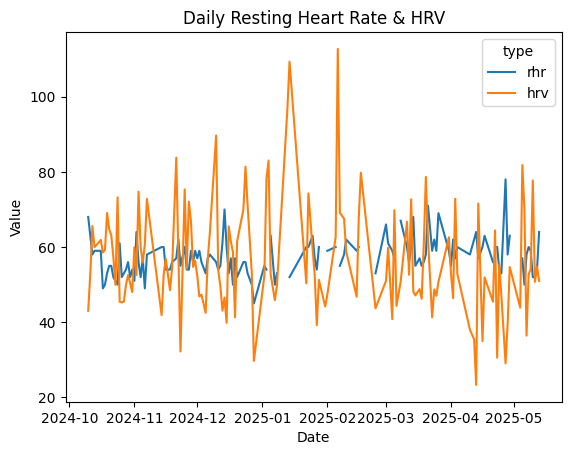

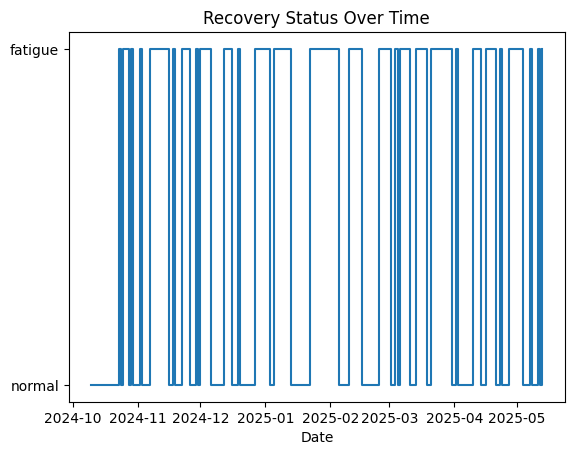

In [14]:
import matplotlib.pyplot as plt

# daily 는 앞에서 만든 DataFrame (index=date, 컬럼: rhr, hrv, recovery_status)

# 1) 일별 RHR vs HRV 추세
plt.figure()
daily[['rhr','hrv']].plot()
plt.title('Daily Resting Heart Rate & HRV')
plt.xlabel('Date')
plt.ylabel('Value')
plt.show()

# 2) 회복 상태 시각화 (normal=0, fatigue=1)
status_map = {'normal': 0, 'fatigue': 1}
plt.figure()
plt.step(daily.index, daily['recovery_status'].map(status_map), where='post')
plt.yticks([0,1], ['normal','fatigue'])
plt.title('Recovery Status Over Time')
plt.xlabel('Date')
plt.show()

<Figure size 640x480 with 0 Axes>

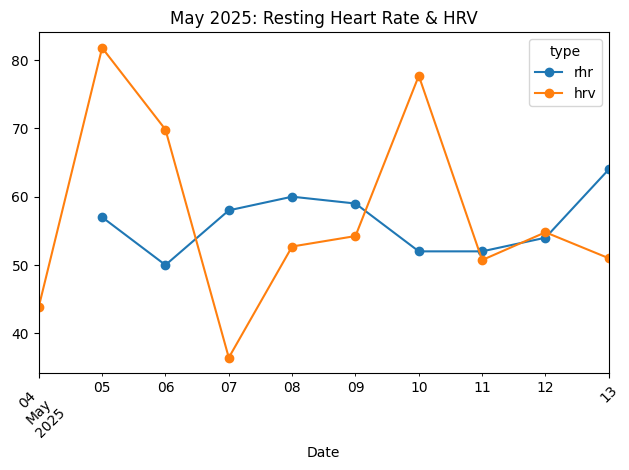

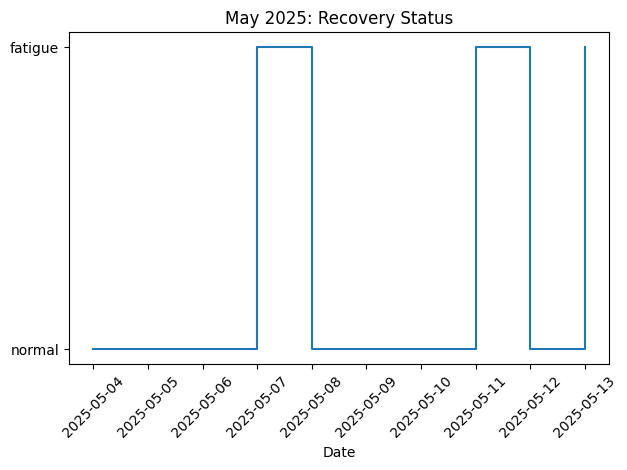

In [17]:
# 1) daily가 이미 정의되어 있다고 가정하고 인덱스 변환
import pandas as pd
daily.index = pd.to_datetime(daily.index)

# 2) 5월 1일~13일 필터
may_data = daily.loc['2025-05-01':'2025-05-13']

# 3) 시각화
import matplotlib.pyplot as plt

plt.figure()
may_data[['rhr','hrv']].plot(marker='o')
plt.title('May 2025: Resting Heart Rate & HRV')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

plt.figure()
status_map = {'normal': 0, 'fatigue': 1}
plt.step(may_data.index, may_data['recovery_status'].map(status_map), where='post')
plt.yticks([0,1], ['normal','fatigue'])
plt.title('May 2025: Recovery Status')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

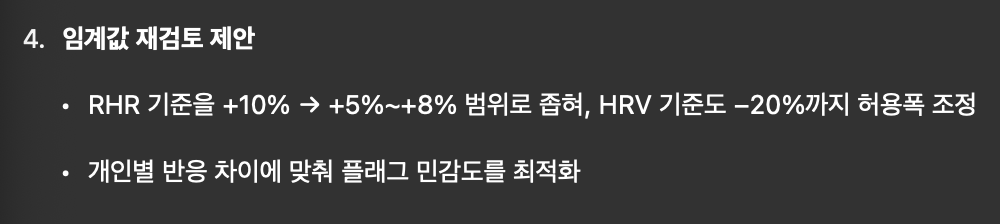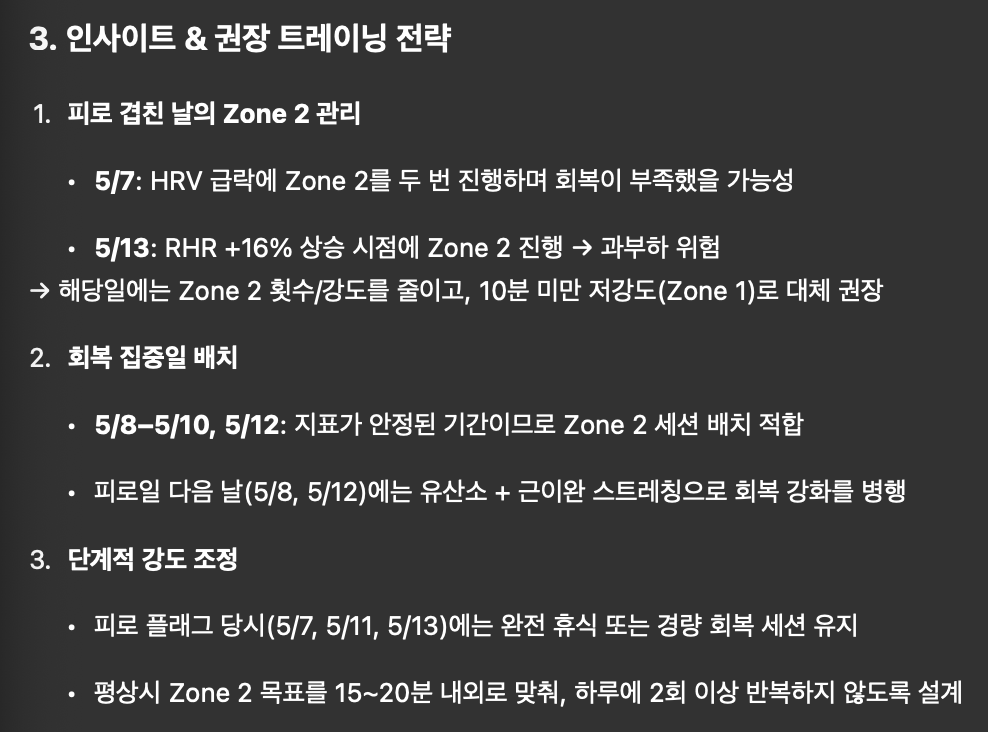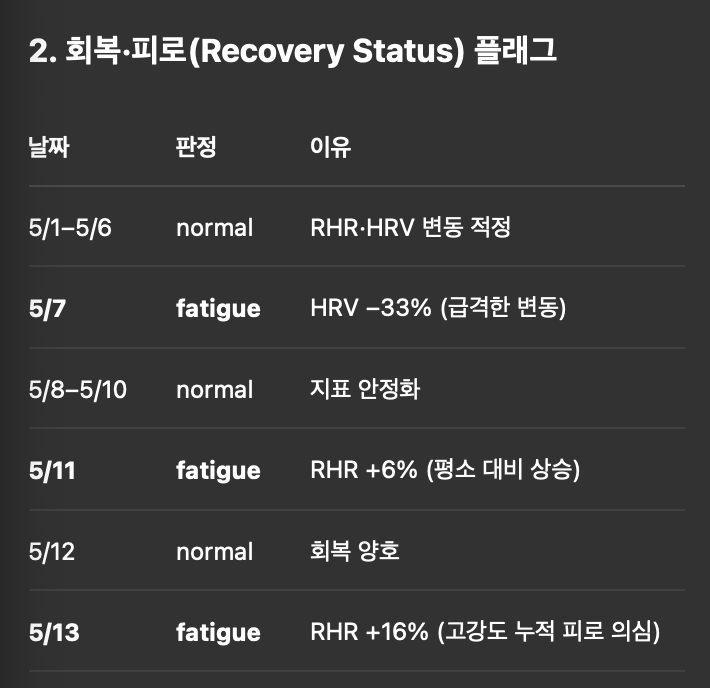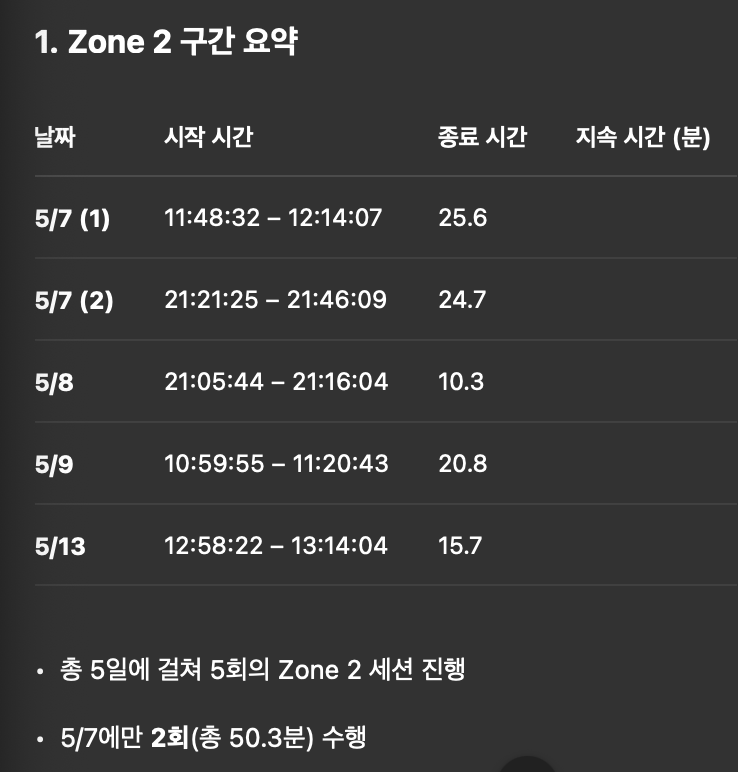